In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Intsall packages

# Drake
!pip install manipulation
# C-Extentions
!pip install cython  
# Pycocotools
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'


# Clone TorchVision references/detection
!git clone https://github.com/pytorch/vision.git
!cd vision && git checkout v0.3.0
!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

from manipulation import running_as_notebook

# Import modules
import fnmatch
import json
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import os
from PIL import Image
from IPython.display import display

import torch
import torch.utils.data

# 0: Red
# 1: Blue
# 2: Green
# 3: Yellow
# 4: Magenta

ycb = [0, 1, 2, 3, 4]

#drake_reserved_labels = [32765, 32764, 32766, 32767]

def colorize_labels(image):
    """Colorizes labels."""
    cc = mpl.colors.ColorConverter()
    color_cycle = plt.rcParams["axes.prop_cycle"]
    colors = np.array([cc.to_rgb(c["color"]) for c in color_cycle])
    bg_color = [0, 0, 0]
    image = np.squeeze(image)
    background = np.zeros(image.shape[:2], dtype=bool)
    for label in reserved_labels:
        background |= image == int(label)
    foreground = image[np.logical_not(background)]
    color_image = colors[image % len(colors)]
    color_image[background] = bg_color
    return color_image


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 610.2/610.2 KB 34.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.2/201.2 KB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.1 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 93.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 761.3/761.3 KB 61.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 80.9 MB/s eta 0:00:00
  Created wheel for timeout-decorator: filename=timeout_decorator-0.5.0-py3-none-any.whl size=5026 sha256=2af6a2ca7fede7428d38adf2d17ee3c544ccbac5c3da8a29244323d62c60e71d
  Stored in directory: /root/.cache/pip/wheels/5d/45/1d/a7d2bf8dfbdecd78983a3d422f2fe860316cfbae3f3b001ea5
  Created wheel for pyngrok: filename=pyngrok-5.2.1-py3-none

In [5]:
# Unzip dataset

dataset_path = "box_maskrcnn_data_2"
if not os.path.exists(dataset_path):
  !cp /content/drive/MyDrive/box_maskrcnn_data_2.zip ./
  !unzip -q box_maskrcnn_data_2.zip

In [6]:
# Dataset class definition

class BinPickingDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.num_images = len(fnmatch.filter(os.listdir(root),'*.png'))
        self.transforms = transforms

    def __getitem__(self, idx):
        filename_base = os.path.join(self.root, f"{idx:05d}")

        img = Image.open(filename_base + ".png").convert("RGB")
        mask = np.squeeze(np.load(filename_base + "_mask.npy"))

        with open(filename_base + ".json", "r") as f:
            instance_id_to_class_name = json.load(f)
        labels = ycb == instance_id_to_class_name

        # instances are encoded as different colors
        obj_ids = np.asarray(list(instance_id_to_class_name.keys()))
        count = (mask == np.int16(obj_ids)[:, None, None]).sum(axis=2).sum(axis=1)
        
        # discard objects instances with less than 10 pixels
        obj_ids = obj_ids[count >= 10]
        
        labels = [ycb.index(instance_id_to_class_name[id]) for id in obj_ids]
        obj_ids = np.int16(np.asarray(obj_ids))

        # split the color-encoded mask into a set of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return self.num_images

In [7]:
# Check the dataset output

dataset = BinPickingDataset(dataset_path)
single = True
if single:
  dataset[0][0]
else:
  for i in range(len(dataset)):
    dataset[i][0]

In [8]:
# Define the network

# Import torchvision
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_Weights

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(
        weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [9]:
# Helper function for data augmentation and transformation

from engine import train_one_epoch, evaluate
import utils
import transforms as T

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [10]:
# Instantiate the dataset and separate

# use our dataset and defined transformations
dataset = BinPickingDataset(dataset_path, get_transform(train=True))
dataset_test = BinPickingDataset(dataset_path, get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [11]:
# Instantiate the model and optimizer

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = len(ycb) + 1

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

In [ ]:
from typing import Tuple, List, Dict, Optional
import torch
from torch import Tensor
from collections import OrderedDict
from torchvision.models.detection.roi_heads import fastrcnn_loss
from torchvision.models.detection.rpn import concat_box_prediction_layers
def eval_forward(model, images, targets):
    # type: (List[Tensor], Optional[List[Dict[str, Tensor]]]) -> Tuple[Dict[str, Tensor], List[Dict[str, Tensor]]]
    """
    Args:
        images (list[Tensor]): images to be processed
        targets (list[Dict[str, Tensor]]): ground-truth boxes present in the image (optional)
    Returns:
        result (list[BoxList] or dict[Tensor]): the output from the model.
            It returns list[BoxList] contains additional fields
            like `scores`, `labels` and `mask` (for Mask R-CNN models).
    """
    model.eval()

    original_image_sizes: List[Tuple[int, int]] = []
    for img in images:
        val = img.shape[-2:]
        assert len(val) == 2
        original_image_sizes.append((val[0], val[1]))

    images, targets = model.transform(images, targets)

    # Check for degenerate boxes
    # TODO: Move this to a function
    if targets is not None:
        for target_idx, target in enumerate(targets):
            boxes = target["boxes"]
            degenerate_boxes = boxes[:, 2:] <= boxes[:, :2]
            if degenerate_boxes.any():
                # print the first degenerate box
                bb_idx = torch.where(degenerate_boxes.any(dim=1))[0][0]
                degen_bb: List[float] = boxes[bb_idx].tolist()
                raise ValueError(
                    "All bounding boxes should have positive height and width."
                    f" Found invalid box {degen_bb} for target at index {target_idx}."
                )

    features = model.backbone(images.tensors)
    if isinstance(features, torch.Tensor):
        features = OrderedDict([("0", features)])
    model.rpn.training=True
    # model.roi_heads.training=True


    # proposals, proposal_losses = model.rpn(images, features, targets)
    features_rpn = list(features.values())
    objectness, pred_bbox_deltas = model.rpn.head(features_rpn)
    anchors = model.rpn.anchor_generator(images, features_rpn)

    num_images = len(anchors)
    num_anchors_per_level_shape_tensors = [o[0].shape for o in objectness]
    num_anchors_per_level = [s[0] * s[1] * s[2] for s in num_anchors_per_level_shape_tensors]
    objectness, pred_bbox_deltas = concat_box_prediction_layers(objectness, pred_bbox_deltas)
    # apply pred_bbox_deltas to anchors to obtain the decoded proposals
    # note that we detach the deltas because Faster R-CNN do not backprop through
    # the proposals
    proposals = model.rpn.box_coder.decode(pred_bbox_deltas.detach(), anchors)
    proposals = proposals.view(num_images, -1, 4)
    proposals, scores = model.rpn.filter_proposals(proposals, objectness, images.image_sizes, num_anchors_per_level)

    proposal_losses = {}
    assert targets is not None
    labels, matched_gt_boxes = model.rpn.assign_targets_to_anchors(anchors, targets)
    regression_targets = model.rpn.box_coder.encode(matched_gt_boxes, anchors)
    loss_objectness, loss_rpn_box_reg = model.rpn.compute_loss(
        objectness, pred_bbox_deltas, labels, regression_targets
    )
    proposal_losses = {
        "loss_objectness": loss_objectness,
        "loss_rpn_box_reg": loss_rpn_box_reg,
    }

    # detections, detector_losses = model.roi_heads(features, proposals, images.image_sizes, targets)
    image_shapes = images.image_sizes
    proposals, matched_idxs, labels, regression_targets = model.roi_heads.select_training_samples(proposals, targets)
    box_features = model.roi_heads.box_roi_pool(features, proposals, image_shapes)
    box_features = model.roi_heads.box_head(box_features)
    class_logits, box_regression = model.roi_heads.box_predictor(box_features)

    result: List[Dict[str, torch.Tensor]] = []
    detector_losses = {}
    loss_classifier, loss_box_reg = fastrcnn_loss(class_logits, box_regression, labels, regression_targets)
    detector_losses = {"loss_classifier": loss_classifier, "loss_box_reg": loss_box_reg}
    boxes, scores, labels = model.roi_heads.postprocess_detections(class_logits, box_regression, proposals, image_shapes)
    num_images = len(boxes)
    for i in range(num_images):
        result.append(
            {
                "boxes": boxes[i],
                "labels": labels[i],
                "scores": scores[i],
            }
        )
    detections = result
    detections = model.transform.postprocess(detections, images.image_sizes, original_image_sizes)  # type: ignore[operator]
    model.rpn.training=False
    model.roi_heads.training=False
    losses = {}
    losses.update(detector_losses)
    losses.update(proposal_losses)
    return losses, detections

In [ ]:
def evaluate_loss(model, data_loader, device):
    val_loss = 0
    with torch.no_grad():
      for images, targets in data_loader:
          images = list(image.to(device) for image in images)
          targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
          losses_dict, detections = eval_forward(model, images, targets)
         
          losses = sum(loss for loss in losses_dict.values())

          val_loss += losses
          
    validation_loss = val_loss/ len(data_loader)    
    return validation_loss


In [ ]:
# Train and evaluate the model

# let's train it for X epochs
num_epochs = 5

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(
        model, optimizer, data_loader, device, epoch, print_freq=10
    )
    # update the learning rate
    lr_scheduler.step()
    # test_loss  = evaluate_loss(model, data_loader_test, device=device)
    # print(test_loss)
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/385]  eta: 0:53:19  lr: 0.000018  loss: 5.3855 (5.3855)  loss_classifier: 2.0118 (2.0118)  loss_box_reg: 0.2553 (0.2553)  loss_mask: 2.3035 (2.3035)  loss_objectness: 0.7735 (0.7735)  loss_rpn_box_reg: 0.0414 (0.0414)  time: 8.3098  data: 0.3962  max mem: 2142
Epoch: [0]  [ 10/385]  eta: 0:07:41  lr: 0.000148  loss: 4.9957 (4.8005)  loss_classifier: 1.7376 (1.6312)  loss_box_reg: 0.4042 (0.4039)  loss_mask: 1.7847 (1.8203)  loss_objectness: 0.7735 (0.8931)  loss_rpn_box_reg: 0.0446 (0.0519)  time: 1.2295  data: 0.0458  max mem: 2420
Epoch: [0]  [ 20/385]  eta: 0:05:34  lr: 0.000278  loss: 3.1584 (3.8540)  loss_classifier: 0.8781 (1.2309)  loss_box_reg: 0.5677 (0.5464)  loss_mask: 1.3632 (1.4300)  loss_objectness: 0.4966 (0.5971)  loss_rpn_box_reg: 0.0422 (0.0495)  time: 0.5460  data: 0.0126  max mem: 2643
Epoch: [0]  [ 30/385]  eta: 0:04:46  lr: 0.000408  loss: 2.5083 (3.3537)  loss_classifier: 0.7729 (1.0672)  loss_box_reg: 0.7484 (0.6116)  loss_mask: 0.7513 (1.1954) 

In [ ]:
# Save model

torch.save(model.state_dict(), 'box_maskrcnn_model_v2.pt')

from google.colab import files
files.download('box_maskrcnn_model_v2.pt') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# pick one image from the test set
img, _ = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [ ]:
# Printing the prediction shows that we have a list of dictionaries. 
# Each element of the list corresponds to a different image. 
# As we have a single image, there is a single dictionary in the list. 
# The dictionary contains the predictions for the image we passed. 
# In this case, we can see that it contains boxes, labels, masks and scores as fields.
prediction

[{'boxes': tensor([[317.0796,  96.8237, 367.0044, 161.6824],
          [296.1068, 190.7375, 339.8210, 244.6134],
          [314.4531, 208.1520, 374.7933, 241.5902],
          [330.7513, 212.6647, 390.9952, 245.9757],
          [296.2657, 187.0650, 333.4860, 216.1329],
          [305.8698, 199.5978, 354.2352, 240.7517],
          [281.5683, 200.4684, 328.5360, 247.6907],
          [275.2345, 243.8860, 332.1109, 282.9610],
          [289.4790, 231.4758, 333.3951, 249.5166],
          [356.9481, 214.6974, 396.3979, 246.9258],
          [303.2405, 190.1718, 345.2505, 225.3317],
          [292.1001, 235.5836, 334.4808, 258.2150],
          [301.3796, 199.9965, 348.6612, 241.6226],
          [303.9781, 199.0609, 327.7428, 242.8238],
          [294.5355, 218.2314, 336.3816, 246.3315],
          [298.4426, 214.5690, 320.0352, 246.0636],
          [263.9703, 207.7230, 312.6088, 248.4113],
          [294.2297, 227.2630, 331.6884, 243.0618],
          [274.9230, 245.5584, 329.5908, 282.7603],
   

In [ ]:
len(prediction[0]['masks'])

20

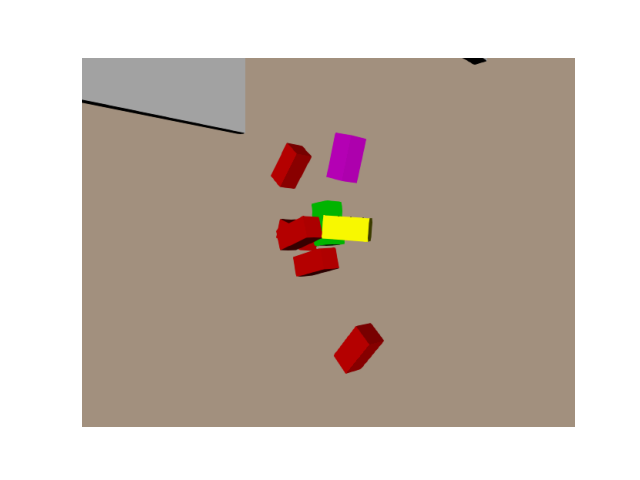

In [ ]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

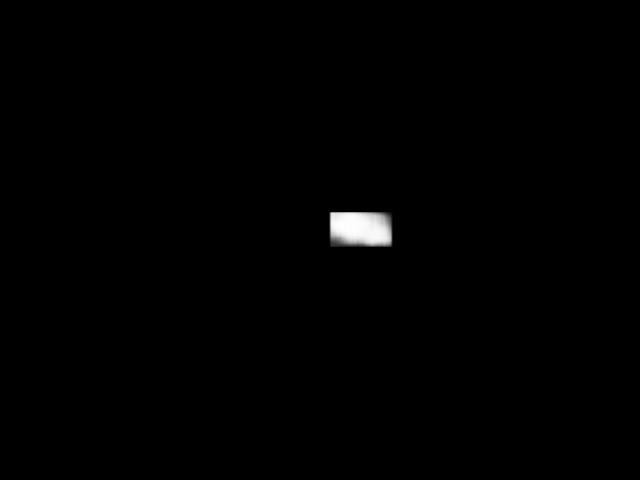

In [ ]:
Image.fromarray(prediction[0]['masks'][4, 0].mul(255).byte().cpu().numpy())